In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import time
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm


In [0]:
# mode='run' if train model on the whole dataset
# mode='test' if train the model on 15% random subset of the dataset (for testing purposes)
# kfold=True if 5-fold mode
# n_fold- number of fold (1 -5) for validation (needed only if kfold=True)
# To train the model in 5 separate kernels choose n_fold=1,...5 in each kernel, then save outputs
mode='run'
kfold=False
n_fold=1
threshold=0.285
one_cycle=True
num_epochs=10
dropout=False

In [0]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


In [0]:
train_df=pd.read_csv("../input/imet-2019-fgvc6/train.csv")
test_df = pd.read_csv("../input/imet-2019-fgvc6/sample_submission.csv")
train_df['attribute_ids']=train_df['attribute_ids'].apply(lambda x:x.split(" "))
test_df['attribute_ids']=test_df['attribute_ids'].apply(lambda x:x.split(" "))


In [0]:
train_df['id']=train_df['id'].apply(lambda x:x+'.png')
test_df1=test_df.copy()
test_df['id']=test_df['id'].apply(lambda x:x+'.png')

In [0]:
label_df=pd.read_csv("../input/imet-2019-fgvc6/labels.csv")

In [0]:
nb_classes=len(label_df)

In [0]:
class iMetDataset(data.Dataset):
    def __init__(self, pd_df, root_dir, transform=None,test=False):
        self.data=pd_df
        self.test=test
        self.labels=self.data.iloc[:,1]
        self.transform=transform
        self.root_dir=root_dir
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.data.iloc[idx, 0])
        image=Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        if not self.test:
            label=self.labels.iloc[idx]
            label_tensor=torch.zeros(1,nb_classes)
            for i in label:
                label_tensor[0,int(i)]=1   
#             image=Image.open(img_name)
#             if self.transform:
#                 image = self.transform(image)
            return [image, label_tensor]
        else:
             return image
        
    

In [0]:

data_transforms={'train': transforms.Compose([transforms.RandomResizedCrop(320,scale=(0.5, 1.5), ratio=(4/5, 5/4)),#transforms.Resize(320),
                                  transforms.RandomHorizontalFlip(),#transforms.RandomRotation(15),
                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
                                   transforms.ToTensor(),transforms.Normalize( [0.485, 0.456, 0.406],
                                                                                          [0.229, 0.224, 0.225])]),
                 'val':transforms.Compose([transforms.RandomResizedCrop(320,scale=(0.5, 1.5), ratio=(4/5, 5/4)),
                                           transforms.ToTensor(), transforms.Normalize( [0.485, 0.456, 0.406], 
                                                                                        [0.229, 0.224, 0.225])])}

                 

In [0]:
val_split=0.9
m=len(train_df)
indices=np.random.permutation(np.arange(m))
if (mode=='test'):
    indices=indices[:int(0.15*len(indices))]
    m=len(indices)
if (not kfold):
    train_data=train_df.iloc[indices][:int(m*val_split)]
    val_data=train_df.iloc[indices][int(m*val_split):]
else:
    # if 5-fold mode - choose 20% of dataset as validation
    val_data=train_df.iloc[indices][int(m*0.2*(n_fold-1)):int(m*0.2*n_fold)]
    train_data=pd.concat([train_df.iloc[indices][:int(m*0.2*(n_fold-1))],
                          train_df.iloc[indices][int(m*0.2*(n_fold)):]],axis=0) 

In [0]:
train_dataset=iMetDataset(train_data,"../input/imet-2019-fgvc6/train",transform=data_transforms['train'])
val_dataset=iMetDataset(val_data,"../input/imet-2019-fgvc6/train",transform=data_transforms['val'])
test_dataset = iMetDataset(test_df, "../input/imet-2019-fgvc6/test",transform=data_transforms['val'],test=True)


In [0]:
val_data.head()

id                   attribute_ids
78322  bc960c61169a7624.png            [13, 405, 896, 1092]
71309  ad3994926ff48544.png            [420, 488, 813, 915]
98342  e89fb5af7f6d648c.png                     [121, 1059]
20707  3d95da7010303ec5.png  [156, 477, 744, 746, 813, 950]
95696  e2db2124e7c59bc4.png                      [813, 896]

In [0]:
image_datasets={'train': train_dataset, 'val': val_dataset}
dataloaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=80, shuffle=True, num_workers=4) 
             for x in ['train', 'val']}
dataloaders['test']=torch.utils.data.DataLoader(test_dataset,batch_size=80, shuffle=False, num_workers=4) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

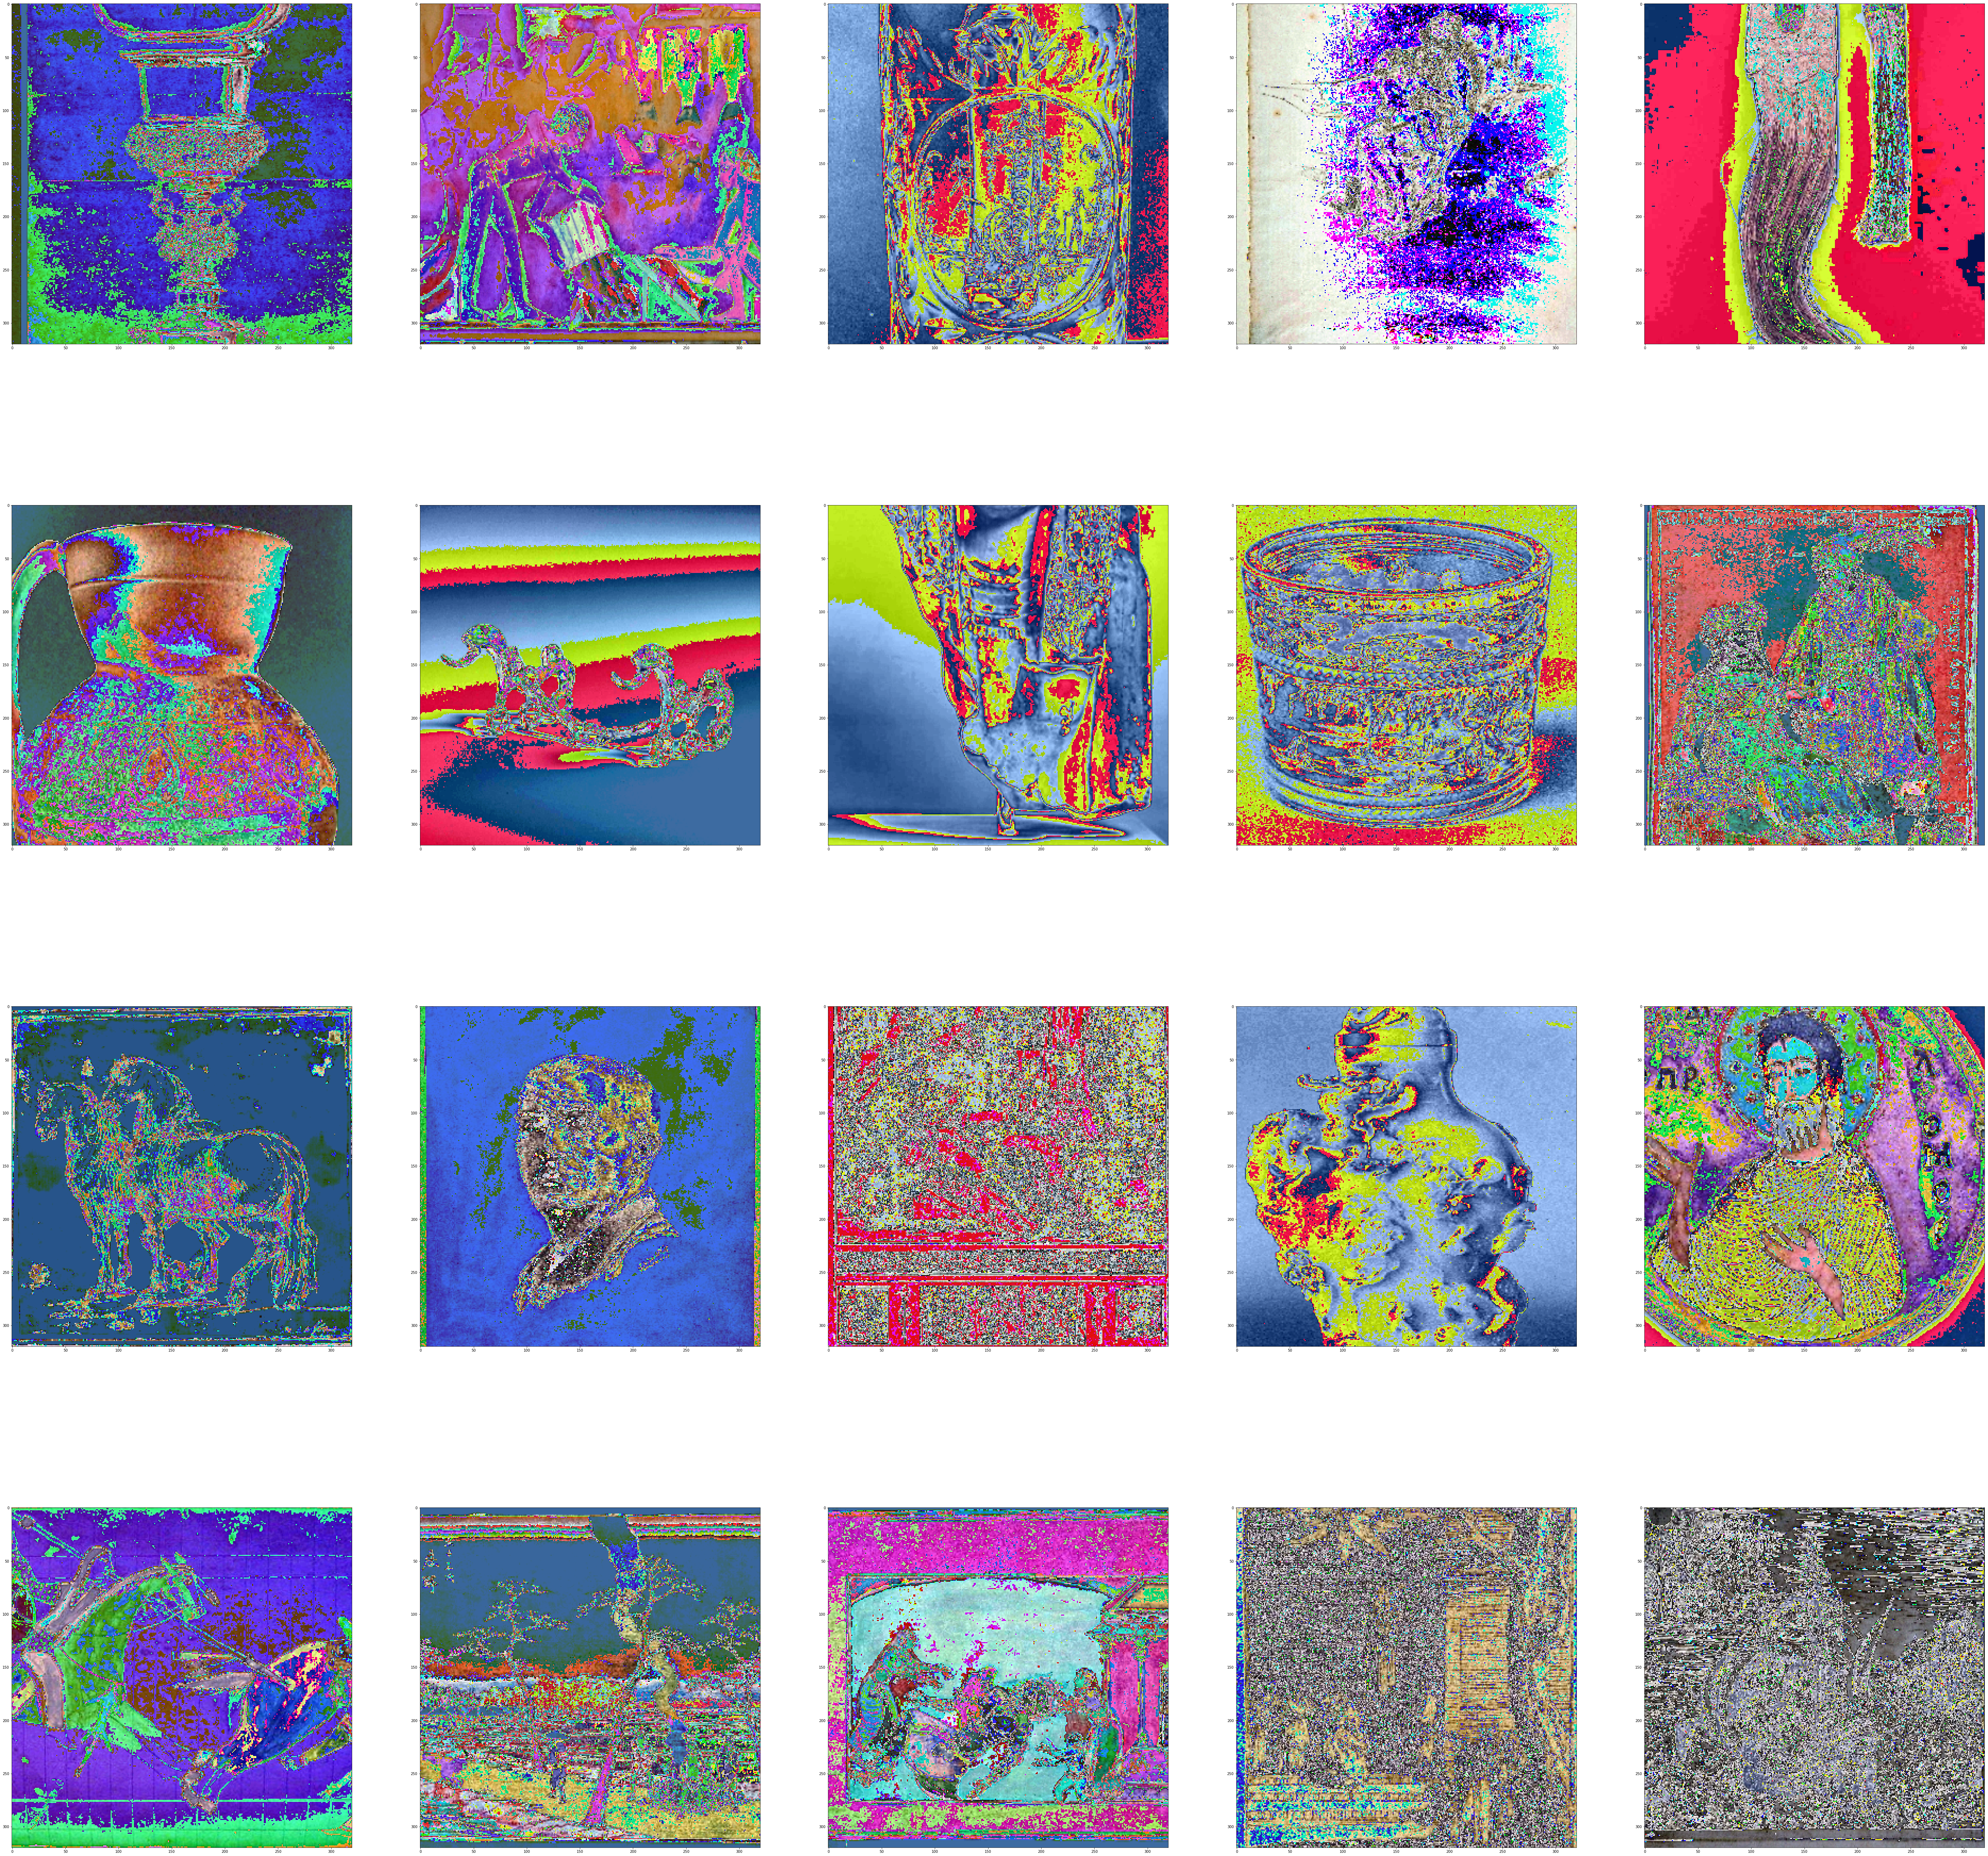

In [0]:
# print 20 images from train dataset
k=0
plt.figure(figsize=[100,100])
for i,label in (dataloaders['train']):
    k+=1
    for j in range(i.shape[0]):
        if (j>=20):
            break    
        plt.subplot(4,5,j+1)    
        plt.imshow(transforms.ToPILImage()(i[j]))
    if (k>=1):
        break
plt.show()

In [0]:
dataset_sizes={x: len(image_datasets[x]) for x in ['train', 'val']}
display(dataset_sizes)

{'train': 98313, 'val': 10924}

In [0]:

def train_model(model,criterion,optimizer,scheduler,num_epochs=10):
    losses={'train': np.zeros(num_epochs), 'val':  np.zeros(num_epochs)}
    accs={'train': np.zeros(num_epochs), 'val':  np.zeros(num_epochs)}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        start_time = time.time()
        print('Epoch {}'.format(epoch))
        for phase in ['train', 'val']:
            if (phase=='train'):
                if ((scheduler is not None)&(not one_cycle)):
                    scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0        
            for inputs,labels in dataloaders[phase]:
                if ((phase=='train') & (one_cycle)):
                    scheduler.step()
                inputs=inputs.to(device)
                labels=labels.to(device)
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    outputs=outputs.float()
                    outputs=outputs.to(device)
                    labels=labels.float()
                    labels = labels.squeeze_()
                    labels=labels.to(device)
                    loss=criterion(outputs,labels)
                    if phase=='train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                running_loss+=loss.item()*inputs.size(0)
                preds_1=Sigmoid(outputs)>threshold
                running_corrects+=f2(labels.float(),preds_1.float())*inputs.size(0)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            losses[phase][epoch]=epoch_loss
            accs[phase][epoch]=epoch_acc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
        elapsed_time = time.time() - start_time
        print('Time: {:.2f} \n'.format(elapsed_time))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    #plot losses and accs
    plt.plot(range(num_epochs),losses['train'],label='train')
    plt.plot(range(num_epochs),losses['val'],label='val')
    plt.title('Loss')
    plt.show()
    plt.plot(range(num_epochs),accs['train'],label='train')
    plt.plot(range(num_epochs),accs['val'],label='val')
    plt.title('Accuracy')
    plt.show()
    return model

             

In [0]:
def Sigmoid(x):
    return(1/(1+torch.exp(-x)))

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
def f2(y_true,y_pred):
    beta=2
    true_positives=torch.sum(y_true*y_pred,1)
    predicted_positives=torch.sum(y_pred,1)
    possible_positives=torch.sum(y_true,1)
    precision=true_positives/(predicted_positives+1e-12)
    recall=true_positives/possible_positives
    f2=(1+beta**2)*precision*recall/(beta**2*precision+recall+1e-12)
    return (f2.mean())

In [0]:
model_ft=models.resnet50()
model_ft.load_state_dict(torch.load('../input/pytorch-pretrained-image-models/resnet50.pth'))
num_features=model_ft.fc.in_features
if dropout:
    model_ft.fc= nn.Dropout(0.2)
    model_ft=nn.Sequential(model_ft, nn.Linear(num_features,nb_classes))
else:    
    model_ft.fc=nn.Linear(num_features,nb_classes)
model_ft=model_ft.to(device)
criterion=FocalLoss(logits=True)




In [0]:
class OneCycleScheduler(object):
    def __init__(self, optimizer, lr, beta, max_steps, annealing):
        self.optimizer = optimizer
        self.lr = lr
        self.beta = beta
        self.max_steps = max_steps
        self.annealing = annealing
        self.epoch = -1
    
    def step(self):
        self.epoch += 1
        
        mid = round(self.max_steps * 0.3)
        if self.epoch < mid:
            r = self.epoch / mid
            lr = self.annealing(self.lr[0], self.lr[1], r)
            beta = self.annealing(self.beta[0], self.beta[1], r)
        else:
            r = (self.epoch - mid) / (self.max_steps - mid)
            lr = self.annealing(self.lr[1], self.lr[0] / 1e4, r)
            beta = self.annealing(self.beta[1], self.beta[0], r)

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
            param_group['betas'] = (beta, *param_group['betas'][1:])

def annealing_linear(start, end, r):
    return start + r * (end - start)            
            
def annealing_cos(start, end, r):
    cos_out = np.cos(np.pi * r) + 1
    return end + (start - end) / 2 * cos_out   




In [0]:

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=0, amsgrad=True)
if (not one_cycle):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
else:
    scheduler = OneCycleScheduler(optimizer_ft, lr=(1e-5, 5e-4), beta=(0.9, 0.8),
                                  max_steps=num_epochs*len(dataloaders['train']), annealing= annealing_linear)

Epoch 0


/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


train Loss: 0.0108 Acc: 0.2982
val Loss: 0.0032 Acc: 0.4200

Time: 1257.83 

Epoch 1
train Loss: 0.0030 Acc: 0.4459
val Loss: 0.0029 Acc: 0.4577

Time: 1262.85 

Epoch 2
train Loss: 0.0028 Acc: 0.4749
val Loss: 0.0028 Acc: 0.4709

Time: 1262.90 

Epoch 3
train Loss: 0.0026 Acc: 0.5039
val Loss: 0.0026 Acc: 0.5135

Time: 1258.98 

Epoch 4
train Loss: 0.0024 Acc: 0.5375
val Loss: 0.0025 Acc: 0.5305

Time: 1257.03 

Epoch 5
train Loss: 0.0022 Acc: 0.5647
val Loss: 0.0024 Acc: 0.5454

Time: 1257.08 

Epoch 6
train Loss: 0.0021 Acc: 0.5900
val Loss: 0.0024 Acc: 0.5561

Time: 1253.88 

Epoch 7
train Loss: 0.0020 Acc: 0.6146
val Loss: 0.0023 Acc: 0.5733

Time: 1258.99 

Epoch 8
train Loss: 0.0018 Acc: 0.6388
val Loss: 0.0022 Acc: 0.5818

Time: 1258.29 

Epoch 9
train Loss: 0.0017 Acc: 0.6624
val Loss: 0.0022 Acc: 0.5861

Time: 1265.08 

Best val Acc: 0.586102


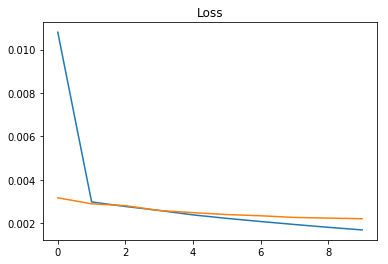

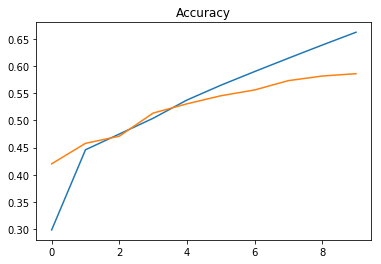

In [0]:

model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler,
                       num_epochs=num_epochs)

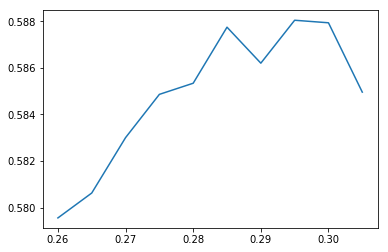

In [0]:

val_acc=[]
choices=np.arange(0.26,0.31,0.005)
for threshold in choices:
    running_corrects=0
    model_ft.eval()
    with torch.no_grad():
        for inputs,labels in dataloaders['val']:
                        inputs=inputs.to(device)
                        labels = labels.squeeze_()
                        labels=labels.to(device)
                        preds=Sigmoid(model_ft(inputs))>threshold
                        running_corrects+=f2(labels.float(),preds.float())*inputs.size(0)
        val_acc.append(running_corrects/dataset_sizes['val'])
val_acc=np.array(val_acc)
plt.plot(choices,val_acc)
plt.show()

In [0]:

threshold_ind=np.argmax(val_acc)
threshold=choices[threshold_ind]
threshold

0.29500000000000004

In [0]:
%%time
prediction = []
# pred_probs=[]
# pred_logits=[]
for inputs in tqdm(dataloaders['test']):
                inputs=inputs.to(device)
                model_ft.eval()
                with torch.no_grad():
                    pred_logit=model_ft(inputs)
                    pred_prob=Sigmoid(pred_logit)
                    preds=pred_prob>threshold
                    for i in range(preds.shape[0]):
                        pred1 = np.argwhere(preds.cpu()[i] == 1.0).reshape(-1).tolist()
                        pred_str = " ".join(list(map(str, pred1)))
                        prediction.append(pred_str)
#                         pred_probs.append(pred_prob.cpu().detach().numpy()[i])
#                         pred_logits.append(pred_logit.cpu().detach().numpy()[i])



CPU times: user 32.7 s, sys: 1min 4s, total: 1min 37s
Wall time: 5min 5s


In [0]:
torch.save(model_ft.state_dict(), 'model.pth')

In [0]:
test_df1.attribute_ids = prediction
test_df1.to_csv("submission.csv", index=False)
test_df1.head()

id                                      attribute_ids
0  1002e7c8e9172e5c                                79 584 738 813 1092
1  10045628394b0c85                                51 718 813 903 1092
2  1006c05aacbeaea6                   51 147 639 671 780 950 1034 1035
3  10073dbee72a9e88                                    121 415 464 955
4  10077d92747afb1a  147 156 189 420 462 519 616 733 734 738 776 81...

In [0]:

# pred_probs_df=pd.DataFrame(data=pred_probs)
# pred_logits_df=pd.DataFrame(data=pred_logits)
# pred_probs_df.to_csv("probs.csv", index=False)
# pred_logits_df.to_csv("logits.csv", index=False)

In [0]:
pred_probs_val=np.zeros((dataset_sizes['val'],nb_classes))
pred_labels_val=np.zeros((dataset_sizes['val'],nb_classes))
true_labels_val=np.zeros((dataset_sizes['val'],nb_classes))
j=0
for inputs,labels in dataloaders['val']:
                inputs=inputs.to(device)
                labels = labels.squeeze_()
                labels=labels.to(device)
                model_ft.eval()
                with torch.no_grad():
                    pred_logit=model_ft(inputs)
                    pred_prob=Sigmoid(pred_logit)
                    preds=pred_prob>threshold
                    for i in range(preds.shape[0]):
                        pred_labels_val[j,:]=preds.cpu().detach().numpy()[i]
                        pred_probs_val[j,:]=pred_prob.cpu().detach().numpy()[i]
                        true_labels_val[j,:]=labels.cpu().detach().numpy()[i]
                        j+=1
    

In [0]:
def f2_labels(y_true,y_pred):
    beta=2
    true_positives=(y_true*y_pred).sum()
    predicted_positives=y_pred.sum()
    possible_positives=y_true.sum()
    precision=true_positives/(predicted_positives+1e-12)
    recall=true_positives/possible_positives
    f2=(1+beta**2)*precision*recall/(beta**2*precision+recall+1e-12)
    return (f2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


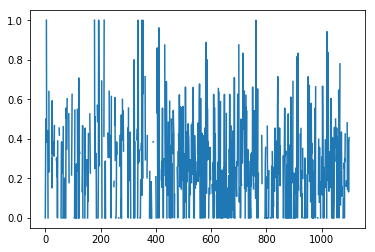

In [0]:
#count f2 metric for each label
f2_classes=np.zeros(nb_classes)
for i in range(nb_classes):
    f2_classes[i]=f2_labels(pred_labels_val[:,i],true_labels_val[:,i])
plt.plot(range(nb_classes),f2_classes)
plt.show()

In [0]:
#labels with zero f2
zero_f2_ind=np.where(f2_classes==0)
zero_f2_ind=(zero_f2_ind)[0]
zero_f2_ind

array([   0,   10,   44,   57,   63,   64,   67,   69,   74,  105,  106,
        110,  113,  120,  122,  136,  141,  143,  153,  171,  185,  191,
        205,  208,  216,  218,  223,  238,  255,  256,  265,  266,  274,
        276,  295,  300,  309,  320,  323,  334,  343,  344,  357,  375,
        377,  382,  385,  398,  401,  407,  408,  412,  427,  440,  449,
        453,  458,  467,  470,  479,  499,  502,  510,  521,  537,  539,
        560,  564,  565,  570,  572,  578,  591,  608,  610,  620,  623,
        627,  632,  636,  638,  640,  641,  646,  654,  660,  662,  669,
        674,  683,  686,  706,  723,  735,  739,  743,  765,  769,  770,
        794,  795,  799,  801,  806,  807,  808,  815,  816,  817,  818,
        824,  839,  842,  861,  862,  869,  874,  876,  878,  880,  881,
        885,  887,  891,  898,  899,  901,  905,  906,  912,  920,  928,
        936,  937,  938,  941,  942,  948,  965,  968,  970,  977,  985,
        986,  996, 1006, 1008, 1018, 1036, 1037, 10

In [0]:
# how many items with labels with zero_f2
count_true_labels={}
for i in zero_f2_ind:
    count_true_labels[str(i)]=np.sum(true_labels_val[:,i])
count_true_labels    

{'0': 2.0,
 '10': 0.0,
 '44': 3.0,
 '57': 0.0,
 '63': 0.0,
 '64': 2.0,
 '67': 2.0,
 '69': 3.0,
 '74': 2.0,
 '105': 3.0,
 '106': 1.0,
 '110': 2.0,
 '113': 2.0,
 '120': 1.0,
 '122': 1.0,
 '136': 2.0,
 '141': 1.0,
 '143': 1.0,
 '153': 0.0,
 '171': 1.0,
 '185': 5.0,
 '191': 6.0,
 '205': 1.0,
 '208': 2.0,
 '216': 0.0,
 '218': 3.0,
 '223': 0.0,
 '238': 3.0,
 '255': 1.0,
 '256': 2.0,
 '265': 5.0,
 '266': 1.0,
 '274': 6.0,
 '276': 7.0,
 '295': 1.0,
 '300': 0.0,
 '309': 4.0,
 '320': 5.0,
 '323': 6.0,
 '334': 7.0,
 '343': 2.0,
 '344': 1.0,
 '357': 1.0,
 '375': 0.0,
 '377': 1.0,
 '382': 2.0,
 '385': 6.0,
 '398': 1.0,
 '401': 1.0,
 '407': 1.0,
 '408': 3.0,
 '412': 8.0,
 '427': 3.0,
 '440': 2.0,
 '449': 6.0,
 '453': 8.0,
 '458': 4.0,
 '467': 4.0,
 '470': 2.0,
 '479': 16.0,
 '499': 5.0,
 '502': 17.0,
 '510': 6.0,
 '521': 4.0,
 '537': 7.0,
 '539': 1.0,
 '560': 2.0,
 '564': 4.0,
 '565': 2.0,
 '570': 16.0,
 '572': 2.0,
 '578': 4.0,
 '591': 8.0,
 '608': 13.0,
 '610': 9.0,
 '620': 15.0,
 '623': 2.0,
 '62

In [0]:
#indices of pictures with zero-f2 labels
ind_true_labels={}
for i in zero_f2_ind:
    if (true_labels_val[:,i]).sum()>0:
        ind_true_labels[str(i)]=np.where(true_labels_val[:,i]==1)
ind_true_labels    

{'0': (array([7685, 9720]),),
 '44': (array([ 5504,  6724, 10517]),),
 '64': (array([ 8734, 10914]),),
 '67': (array([1896, 9080]),),
 '69': (array([ 6088,  9210, 10399]),),
 '74': (array([7230, 8878]),),
 '105': (array([7594, 8135, 8287]),),
 '106': (array([8090]),),
 '110': (array([ 8554, 10531]),),
 '113': (array([4510, 7147]),),
 '120': (array([10396]),),
 '122': (array([6749]),),
 '136': (array([ 6504, 10272]),),
 '141': (array([5551]),),
 '143': (array([7011]),),
 '171': (array([3956]),),
 '185': (array([ 2311,  3937,  3974,  8554, 10531]),),
 '191': (array([1577, 2538, 3340, 4378, 5055, 5505]),),
 '205': (array([6848]),),
 '208': (array([ 995, 8412]),),
 '218': (array([1375, 2911, 4052]),),
 '238': (array([3969, 5816, 7107]),),
 '255': (array([8092]),),
 '256': (array([ 443, 8677]),),
 '265': (array([3704, 5176, 6071, 7878, 8552]),),
 '266': (array([3940]),),
 '274': (array([2899, 5926, 7460, 9494, 9528, 9820]),),
 '276': (array([ 3390,  4837,  5841,  8581,  9128,  9552, 10712])

In [0]:
#predicted probs for these labels
probs_true_labels={}
for i in ind_true_labels.keys():
    probs_true_labels[i]=pred_probs_val[ind_true_labels[i][0],int(i)]
probs_true_labels

{'0': array([0.09709104, 0.24091882]),
 '44': array([0.13347803, 0.08554913, 0.1001179 ]),
 '64': array([0.18472722, 0.12832627]),
 '67': array([0.240747  , 0.07668002]),
 '69': array([0.17795637, 0.09491947, 0.22205897]),
 '74': array([0.21843585, 0.21803972]),
 '105': array([0.18699288, 0.23149304, 0.09746854]),
 '106': array([0.06716767]),
 '110': array([0.18534516, 0.17637739]),
 '113': array([0.07027464, 0.15815407]),
 '120': array([0.07616627]),
 '122': array([0.236672]),
 '136': array([0.06653336, 0.29355311]),
 '141': array([0.12337617]),
 '143': array([0.05852412]),
 '171': array([0.21930735]),
 '185': array([0.23148891, 0.02811946, 0.05718602, 0.21751338, 0.17380919]),
 '191': array([0.0315559 , 0.14552024, 0.25745168, 0.19070639, 0.09704646,
        0.15699999]),
 '205': array([0.1811278]),
 '208': array([0.19664451, 0.22864997]),
 '218': array([0.22436982, 0.21330038, 0.10597593]),
 '238': array([0.05937006, 0.27661505, 0.1366431 ]),
 '255': array([0.04514169]),
 '256': arr

In [0]:
rare_ind=ind_true_labels.keys()
rare_ind=[int(x) for x in rare_ind]

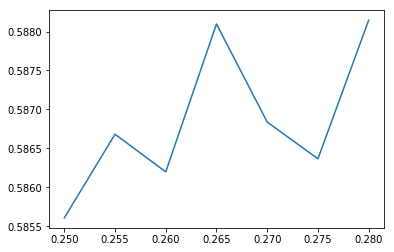

In [0]:
#tuning threshold for this group of items
val_acc=[]
choices=np.arange(0.25,0.28,0.005)

for threshold_rare in choices:
    running_corrects=0
    model_ft.eval()
    with torch.no_grad():
            for inputs,labels in dataloaders['val']:
                            inputs=inputs.to(device)
                            labels = labels.squeeze_()
                            labels=labels.to(device)
                            probs=Sigmoid(model_ft(inputs))
                            preds=probs>threshold
                            preds[:,rare_ind]=probs[:,rare_ind]>threshold_rare
                            running_corrects+=f2(labels.float(),preds.float())*inputs.size(0)
            val_acc.append(running_corrects/dataset_sizes['val'])
val_acc=np.array(val_acc)
plt.plot(choices,val_acc)
plt.show()
